## Re-fit ( Re-build and fine-Tune) method:

This method tries to combat the CodeBook collapse, i.e(dead codes phenomenon where only a small subset of codes are used by the encoder from the whole codebook), it was first introduced in the paper : https://arxiv.org/pdf/2112.01799

In the best scenario, We want our codeBook to be initialized in a manner where it has a prior on our dataset, so the codes and the encoders outputs are more alligned, hence the distances between them isn't that huge, The idea proposed in the article is simple : take a pre-trained Vq-Vae trained on a random intilialised codebook, then do a pass through all the dataset and encode allthe images using the encoder, we end by a huge matrix, then we apply a K-means on all the vectors to take the centroids, and train a new model whose codebbok is initialized with those centroids.

We can note the following : 
*   The nw model is still inspired by the previous CodeBook, so note that any enhancement made on the previous can strongly increase the new model, inversely, if we start from a bad model, this mehtod could not help much
*   we can highly decrease the number of codes used in this new model $K' << K$ without loosing much informations. after all, experiments show that only $20 \% $ codes are used form a randomly initialized codebook. 
*   Note here the necessity for this new model with reduced K, to use as the same encoder and decoder of th previous model, after all; the method called fine-tuning; this is a crucial point, otherwise we observe a huge downgrade if weights are initilaized radnomly. 

In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from utils.vqVAE import VQVAE
# from vqVAE_custom import VQVAE
from utils.training import *


import warnings
warnings.filterwarnings("ignore")

In [2]:
in_channels = 4 
L = 128 # image size L=W
BATCH_SIZE = 16

new_K = 128 # We divided the number of codes by 4
D = 64


### Calling the DataSet

In [3]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


In [4]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

In [5]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [6]:
model_path = 'saved_models/vqvae_100_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

In [7]:
# saving the previous model encoder and decoder : 

# Load the saved model checkpoint
checkpoint = torch.load(model_path)
# Filter the encoder parameters
encoder_state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith('encoder.')}
# Filter the decoder parameters
decoder_state_dict = {k: v for k, v in checkpoint['model_state_dict'].items() if k.startswith('decoder.')}

In [8]:
# we are going to pass through the whole dataset, which results on 

latent_vectors = []

# Process the dataset
with torch.no_grad():  # No need to track gradients
    for batch in TrainLoader:
        # Pass the batch through the encoder
        encoded = model.encode(batch.float().to(device))[0]  # Output shape: (batch_size, 32, 32, 32)
        
        # Flatten the encoded output to (batch_size, 32*32)
        encoded_flat = encoded.view(encoded.size(0), 64, -1).permute(0, 2, 1)  # Shape: (batch_size, 1024, 64)
        
        # Now flatten across the batch and spatial dimensions to (batch_size * 1024, 64)
        encoded_flat = encoded_flat.reshape(-1, 64)
        
        # Convert the tensor to NumPy and store it
        latent_vectors.append(encoded_flat.cpu().numpy())

# Concatenate all the latent vectors into a single NumPy array
latent_vectors = np.concatenate(latent_vectors, axis=0)  # Shape: (size_of_dataset, 32*32)

# # Optionally, save the latent vectors to disk
# np.save('latent_vectors.npy', latent_vectors)

In [9]:

from sklearn.cluster import kmeans_plusplus

# Calculate seeds from k-means++
centers_init, indices = kmeans_plusplus(latent_vectors, n_clusters= new_K)


In [10]:
# # let's take just P samples from the whole distribution : 
# P = 100000

# total_vectors = latent_vectors.shape[0]

# # Randomly sample N unique indices from the range of total_vectors
# sample_indices = np.random.choice(total_vectors, size=P, replace=False)

# # Extract the corresponding vectors
# latent_vectors_red = latent_vectors[sample_indices, :]  # Shape: (N, 64)

In [12]:

codebook = model.vq_layer.embedding.weight.data.cpu().detach()

In [ ]:
#Projection using UMAP

# import umap
# import numpy as np

# reducer = umap.UMAP(n_components=2, random_state=42)

# # Fit and transform
# d2_latent_vectors_red = reducer.fit_transform(latent_vectors_red)
# d2_centers_init       = reducer.transform(centers_init)
# d2_codebook_vecs      = reducer.transform(np.array(codebook))


In [14]:
# from sklearn.manifold import TSNE

# # Perform t-SNE projection into 2D space
# tsne = TSNE(n_components=2, random_state=42)
# X_2d = tsne.fit_transform(latent_vectors_red)



In [15]:
# # Plotting the 2D projection
# plt.figure(figsize = (20,20))
# plt.scatter(X_2d[:, 0], X_2d[:, 1], cmap='viridis', s=0.5)
# plt.title("t-SNE Projection into 2D Space")
# plt.xlabel("t-SNE 1")
# plt.ylabel("t-SNE 2")
# plt.show()

In [16]:
plt.figure(figsize=(70,60))
# Plot the results
plt.scatter(d2_latent_vectors_red[:, 0], d2_latent_vectors_red[:, 1], s = 1,label= 'latents distribution')
plt.scatter(d2_centers_init[:, 0], d2_centers_init[:, 1], s = 200, c='green', label = 'k-means++ centroids')
plt.scatter(d2_codebook_vecs[:,0], d2_codebook_vecs[:,1], s=200, c = 'red', label = 'codeBook codes')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')

plt.legend()
plt.show()

NameError: name 'd2_latent_vectors_red' is not defined

<Figure size 7000x6000 with 0 Axes>

In [17]:
# from utils.training import *

In [18]:
### Learning parameters
new_codebook = torch.from_numpy(centers_init)

ACDC_VQVAE = VQVAE(in_channels, D, new_K, embedding = new_codebook)
model = ACDC_VQVAE.to(device)



In [19]:
#testing intialization.

codebook2 = model.vq_layer.embedding # must be equalt to centroids
print(((codebook2.weight.data.cpu()-new_codebook)**2).mean() )

tensor(0.)


In [20]:
# Load the encoder and decoder weights into the new model
# Remove the 'encoder.' prefix from all keys in encoder_state_dict
encoder_state_dict = {k.replace('encoder.', ''): v for k, v in encoder_state_dict.items()}
model.encoder.load_state_dict(encoder_state_dict)

# Remove the 'encoder.' prefix from all keys in encoder_state_dict
decoder_state_dict = {k.replace('decoder.', ''): v for k, v in decoder_state_dict.items()}
model.decoder.load_state_dict(decoder_state_dict)

<All keys matched successfully>

In [21]:
lr = 5e-4
epochs = 50
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'Re_Fit_models/vqvae_101_bestmodel.pth'

In [23]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [24]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, dice_loss, device)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:06<00:00, 19.45batch/s, loss=0.00255]


Epoch 0: Train Loss: 0.0025


100%|██████████| 119/119 [00:05<00:00, 19.86batch/s, loss=0.00254]


Epoch 1: Train Loss: 0.0021


100%|██████████| 119/119 [00:05<00:00, 20.30batch/s, loss=0.00208]


Epoch 2: Train Loss: 0.0022


100%|██████████| 119/119 [00:05<00:00, 20.33batch/s, loss=0.00191]


Epoch 3: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 20.18batch/s, loss=0.0023] 


Epoch 4: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.98batch/s, loss=0.00192]


Epoch 5: Train Loss: 0.0022


100%|██████████| 119/119 [00:05<00:00, 20.68batch/s, loss=0.00211]


Epoch 6: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.76batch/s, loss=0.00216]


Epoch 7: Train Loss: 0.0019


100%|██████████| 119/119 [00:06<00:00, 19.20batch/s, loss=0.00173]


Epoch 8: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 20.82batch/s, loss=0.00219]


Epoch 9: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.66batch/s, loss=0.00186]


Epoch 10: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.87batch/s, loss=0.002]  


Epoch 11: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 20.61batch/s, loss=0.00226]


Epoch 12: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.98batch/s, loss=0.00163]


Epoch 13: Train Loss: 0.0018


100%|██████████| 119/119 [00:06<00:00, 19.80batch/s, loss=0.00196]


Epoch 14: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.56batch/s, loss=0.00171]


Epoch 15: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 20.50batch/s, loss=0.0021] 


Epoch 16: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.29batch/s, loss=0.00185]


Epoch 17: Train Loss: 0.0018


100%|██████████| 119/119 [00:05<00:00, 21.12batch/s, loss=0.00165]


Epoch 18: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 23.37batch/s, loss=0.00247]


Epoch 19: Train Loss: 0.0019


100%|██████████| 119/119 [00:05<00:00, 20.84batch/s, loss=0.00151]


Epoch 20: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.45batch/s, loss=0.0015] 


Epoch 21: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.41batch/s, loss=0.00184]


Epoch 22: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.51batch/s, loss=0.00177]


Epoch 23: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 20.55batch/s, loss=0.00164]


Epoch 24: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.78batch/s, loss=0.0017] 


Epoch 25: Train Loss: 0.0014


100%|██████████| 119/119 [00:05<00:00, 20.98batch/s, loss=0.00186]


Epoch 26: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 21.02batch/s, loss=0.00133]


Epoch 27: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.93batch/s, loss=0.00168]


Epoch 28: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.69batch/s, loss=0.00196]


Epoch 29: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.84batch/s, loss=0.00138]


Epoch 30: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 21.02batch/s, loss=0.00185]


Epoch 31: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.93batch/s, loss=0.00161]


Epoch 32: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.31batch/s, loss=0.00148]


Epoch 33: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.78batch/s, loss=0.0016] 


Epoch 34: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.74batch/s, loss=0.00329]


Epoch 35: Train Loss: 0.0020


100%|██████████| 119/119 [00:05<00:00, 20.85batch/s, loss=0.0015] 


Epoch 36: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 20.34batch/s, loss=0.00114]


Epoch 37: Train Loss: 0.0013


100%|██████████| 119/119 [00:05<00:00, 20.22batch/s, loss=0.000956]


Epoch 38: Train Loss: 0.0012


100%|██████████| 119/119 [00:05<00:00, 20.50batch/s, loss=0.00127]


Epoch 39: Train Loss: 0.0012


100%|██████████| 119/119 [00:05<00:00, 20.75batch/s, loss=0.00133]


Epoch 40: Train Loss: 0.0013


100%|██████████| 119/119 [00:05<00:00, 20.62batch/s, loss=0.00174]


Epoch 41: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.81batch/s, loss=0.0013] 


Epoch 42: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.89batch/s, loss=0.00188]


Epoch 43: Train Loss: 0.0017


100%|██████████| 119/119 [00:05<00:00, 21.23batch/s, loss=0.00137]


Epoch 44: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.66batch/s, loss=0.00145]


Epoch 45: Train Loss: 0.0014


100%|██████████| 119/119 [00:05<00:00, 21.12batch/s, loss=0.00146]


Epoch 46: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 21.10batch/s, loss=0.00152]


Epoch 47: Train Loss: 0.0015


100%|██████████| 119/119 [00:05<00:00, 20.73batch/s, loss=0.00174]


Epoch 48: Train Loss: 0.0016


100%|██████████| 119/119 [00:05<00:00, 20.53batch/s, loss=0.00164]


Epoch 49: Train Loss: 0.0016
Training complete.


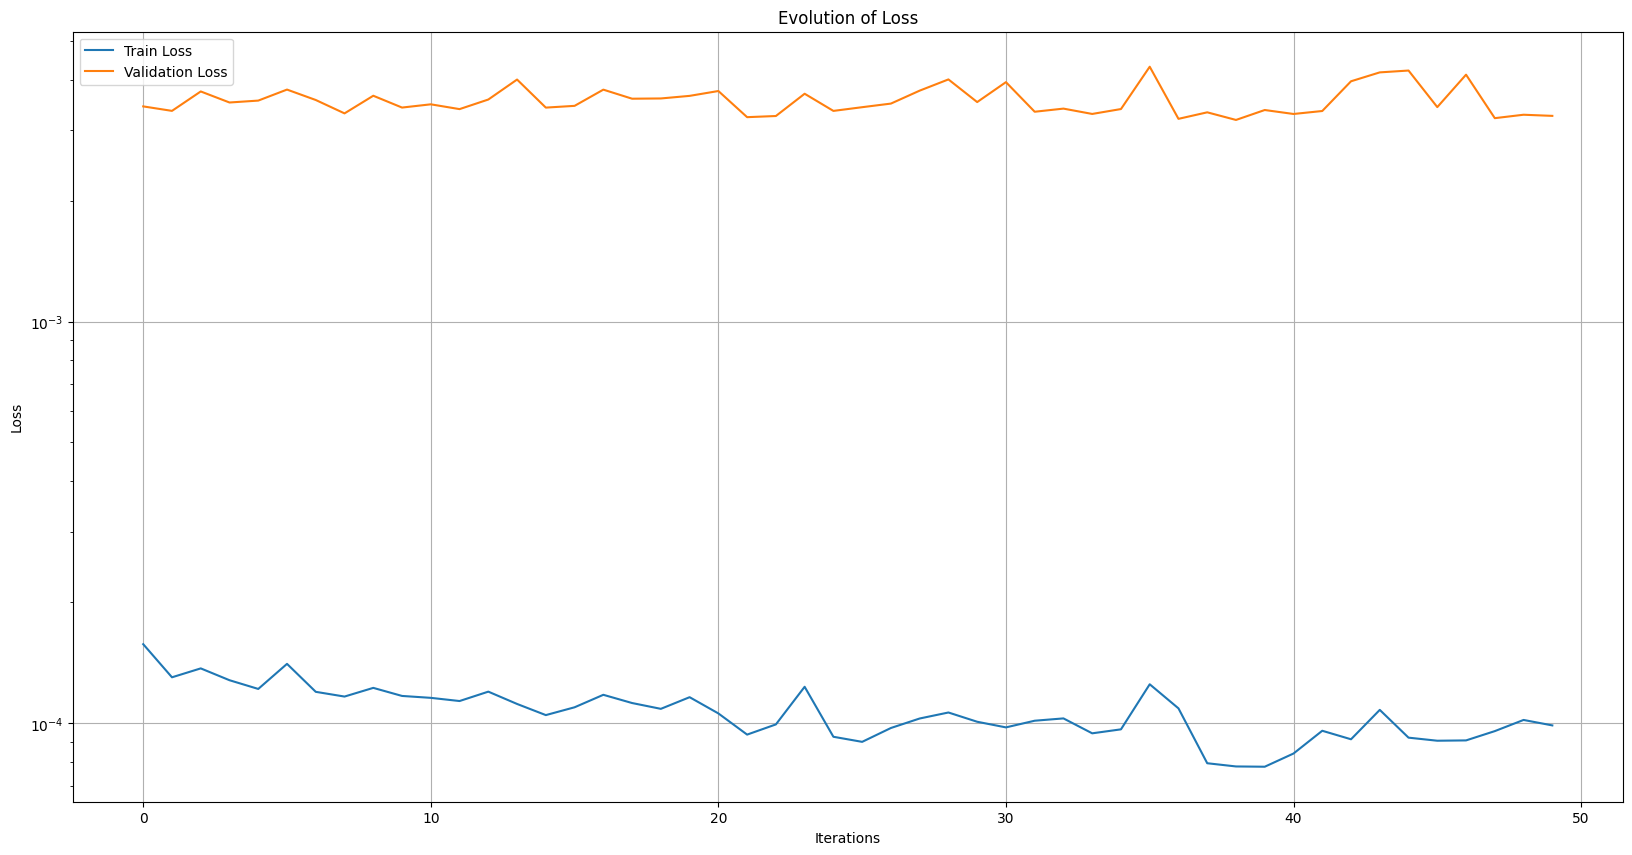

In [25]:
plot_train_val_loss(train_loss_values, val_loss_values)

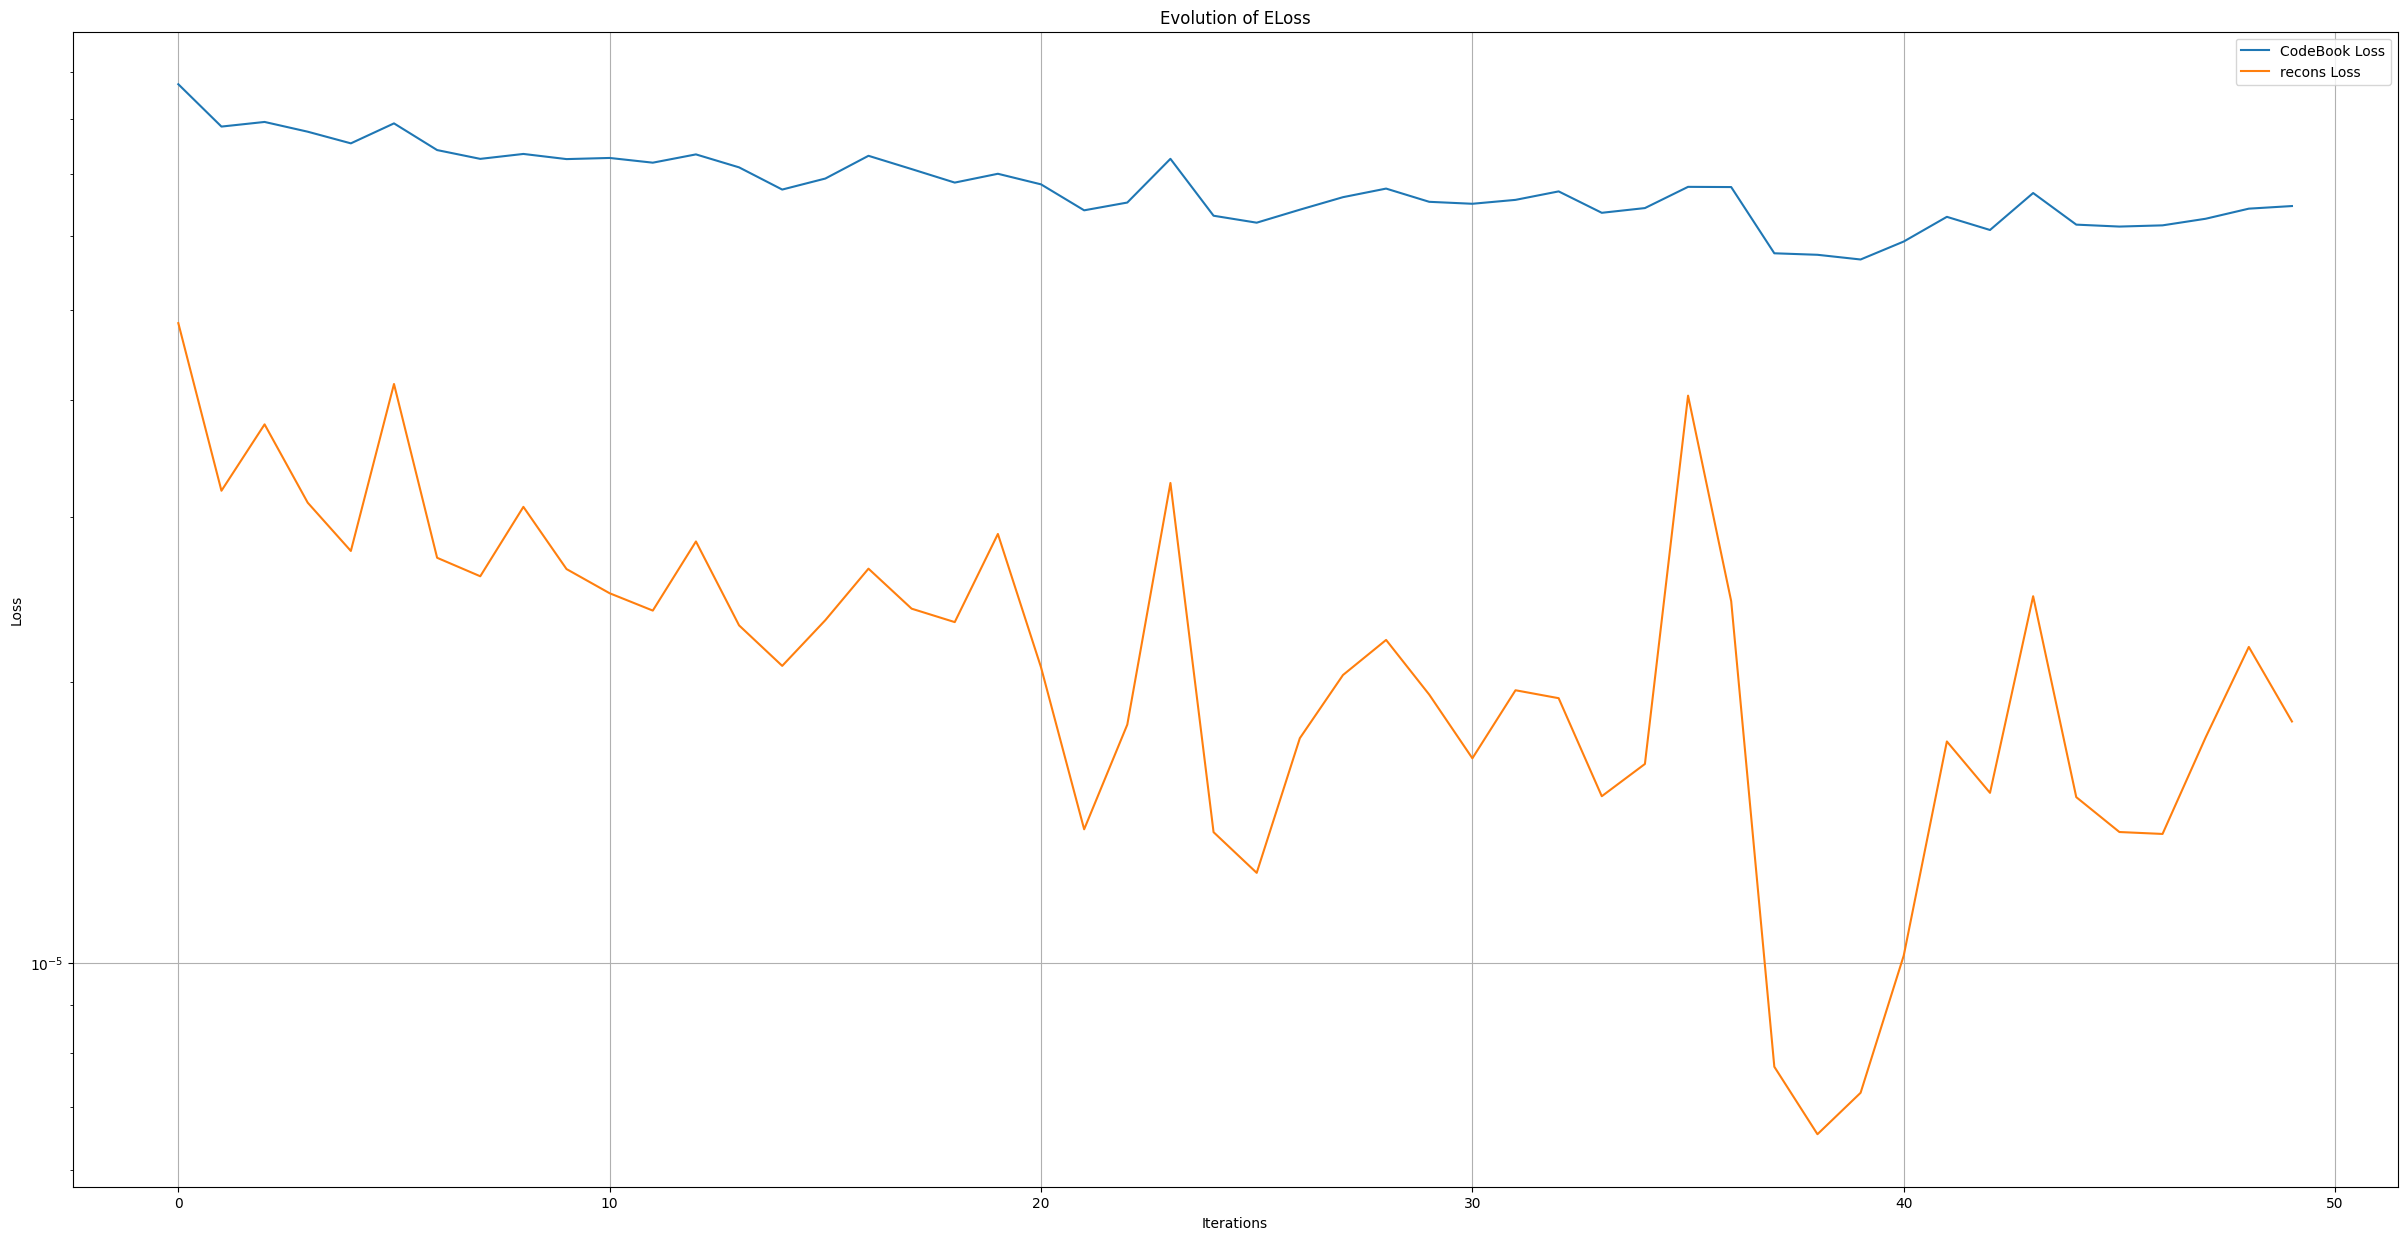

In [26]:


# plot_rc_loss(train_loss_values, codebook_loss_values, beta=0.25)

recons_loss_values = np.array(train_loss_values) - ( (1+0.25)*np.array(codebook_loss_values))
# Plot the training and validation losses
plt.figure(figsize=(30, 15))
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Validation Loss')
plt.plot(codebook_loss_values, label = "CodeBook Loss")
# plt.plot(commit_loss_values, label = "Committement Loss")
plt.plot(recons_loss_values, label = "recons Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of ELoss')
plt.legend()
plt.grid()
plt.show()



In [1]:
# visualize_batch_logits( recons_evolution[-1].detach().cpu() , title='')

In [2]:
# visualize_batch_logits( recons_evolution[0].detach().cpu() , title='')